🛸 Space Titanic | EDA | Advanced Feature Engineering: [https://www.kaggle.com/competitions/spaceship-titanic/overview](https://www.kaggle.com/competitions/spaceship-titanic/overview)



train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.


Stick out:
- PassengerId which has a group component to it meaning that those people may be more likely to stick together.
- Cryosleep passengers are confined to their cabins meaning we could figure out if it was locational.
- Cabin has the locational information. Useful for cryosleep and general locations of people.
- Amount spent at each luxury could give insight into where the passengers were located on the ship the most.
- VIP could have been in a separate room
- Transported is the target column.

Maybe:
- HomePlanet - Given that all people had boarded the ship prior to the incident.
- Destination - Given that all people were still in transit and no dropoffs had been made.
- Age - If they saved children over elderly or something along those lines.
- Name - Check last names for groups although most likely already together by group ID from passenger ID

In [58]:
import pandas as pd
from pathlib import Path

# notebooks/01_eda.ipynb -> repo_root/data
DATA_DIR = Path.cwd().parent / "data"

train_path = DATA_DIR / "train.csv"
test_path = DATA_DIR / "test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("train:", train_df.shape)
print("test :", test_df.shape)
print("train types:", train_df.dtypes)

train: (8693, 14)
test : (4277, 13)
train types: PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object


Remove duplicates and check target value.

In [59]:
# Remove duplicate Passenger IDs
train_df["PassengerId"].drop_duplicates()

# Normalize Target Value
train_df["Transported"].value_counts(normalize=True)

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64

In [60]:
# Check missing counts for each
train_df.isna().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
Spa             183
FoodCourt       183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

In [61]:
test_df.isna().sum().sort_values(ascending=False)

FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
VIP              93
CryoSleep        93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64

First I want to separate out some of the datatypes that are combined.

From passenger ID I will add a new integer called GroupID
From Cabin we can extract the deck number and side.

And we should check why CryoSleep and VIP are object types rather than booleans (probably nulls)

We can also check if null has any correlation with the transported value for each column.

In [62]:
# Group ID column
train_df["GroupId"] = train_df["PassengerId"].str.split("_").str[0].astype("Int64")

def cabin_deck(x):
    if pd.isna(x):
        return pd.NA
    x = str(x).strip()
    if len(x) != 1:
        return pd.NA
    return ord(x) - ord("A")

def cabin_side(x):
    if pd.isna(x):
        return pd.NA
    x = str(x).strip().upper()
    return {"P": 0, "S": 1}.get(x, pd.NA)


# Cabin Deck, Num, Side columns
cabin_parts = train_df["Cabin"].str.split("/", expand=True)

train_df["CabinDeck"] = cabin_parts.get(0).map(cabin_deck).astype("Int64")
train_df["CabinNum"] = (pd.to_numeric(cabin_parts.get(1), errors="coerce").astype("Int64"))
train_df["CabinSide"] = cabin_parts.get(2).map(cabin_side).astype("Int64")

# Normalize Booleans
train_df["CryoSleep"] = train_df["CryoSleep"].replace({"True": True, "False": False}).astype("boolean")
train_df["VIP"] = train_df["VIP"].replace({"True": True, "False": False}).astype("boolean")

print(train_df.head(1))

  PassengerId HomePlanet  CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa      False  B/0/P  TRAPPIST-1e  39.0  False   

   RoomService  FoodCourt  ShoppingMall  Spa  VRDeck             Name  \
0          0.0        0.0           0.0  0.0     0.0  Maham Ofracculy   

   Transported  GroupId  CabinDeck  CabinNum  CabinSide  
0        False        1          1         0          0  


In [63]:
print(train_df.dtypes)

PassengerId      object
HomePlanet       object
CryoSleep       boolean
Cabin            object
Destination      object
Age             float64
VIP             boolean
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
GroupId           Int64
CabinDeck         Int64
CabinNum          Int64
CabinSide         Int64
dtype: object


In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.tree import DecisionTreeClassifier

pio.renderers.default = "vscode"

## Helper Functions



In [65]:
def summary_table(df, column, target="Transported", sort="abs_delta", ascending=False):
    overall = df[target].dropna().mean()

    return (
      df.dropna(subset=[target])
      .groupby(column)[target]
      .agg(n="size", rate="mean")
      .assign(delta_vs_overall=lambda t: t["rate"] - overall)
      .assign(abs_delta= lambda t: abs(t["delta_vs_overall"]))
      .sort_values(sort, ascending=ascending)
      .drop(columns="abs_delta")
    )

## Overall Transported Rate

In [66]:
df = train_df.copy()

overall = df["Transported"].dropna().mean()

overall

np.float64(0.5036236051995858)

## Cryo Sleep

I'll start with CryoSleep since I believe it will be a strong predictor.

In [67]:
df = train_df.copy()

df["CryoSleep"] = df["CryoSleep"].astype("string").fillna("Missing")

summary_table(df, "CryoSleep")

,n,rate,delta_vs_overall
CryoSleep,,,
True,3037,0.817583,0.313960
False,5439,0.328921,-0.174703
Missing,217,0.488479,-0.015144


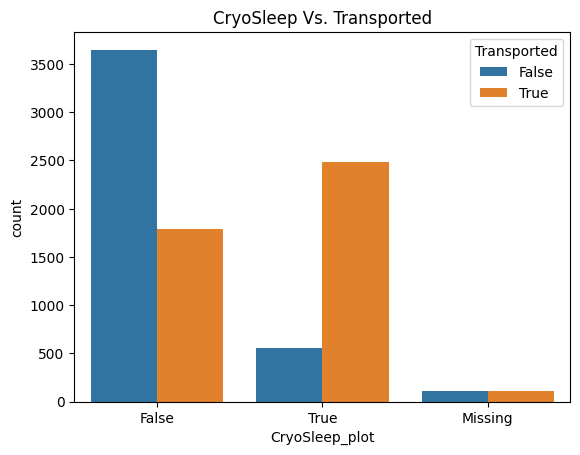

In [68]:
df = train_df.copy()

df["CryoSleep_plot"] = df["CryoSleep"].astype("string").replace({True: "True", False: "False"}).fillna("Missing")

sns.countplot(data=df, x="CryoSleep_plot", hue="Transported")
plt.title("CryoSleep Vs. Transported")
plt.show()

## Home Planet

In [69]:
df = train_df.copy()

df["HomePlanet"] = df["HomePlanet"].fillna("Missing")

overall = df["Transported"].dropna().mean()

summary_table(df, "HomePlanet")

,n,rate,delta_vs_overall
HomePlanet,,,
Europa,2131,0.658846,0.155222
Earth,4602,0.423946,-0.079677
Mars,1759,0.523024,0.019401
Missing,201,0.512438,0.008814


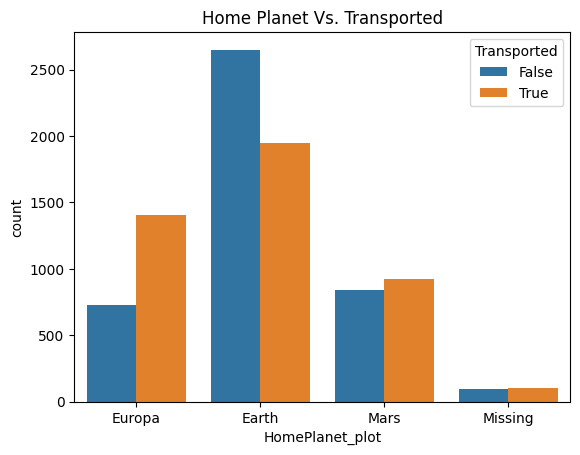

In [70]:
df = train_df.copy()
df["HomePlanet_plot"] = df["HomePlanet"].fillna("Missing")

sns.countplot(data=df, x="HomePlanet_plot", hue="Transported")
plt.title("Home Planet Vs. Transported")
plt.show()

Earth and Europa show strong differences when compared to the overall with Europa at 15 points higher and Earth at 8 points lower.

Now we can check for proxy/confounding with CryoSleep

In [71]:
df = train_df.copy()

df["HomePlanet_f"] = df["HomePlanet"].fillna("Missing")
df["CryoSleep_f"] = df["CryoSleep"].astype("string").fillna("Missing")

rate_pivot = df.pivot_table(
    index="HomePlanet_f",
    columns="CryoSleep_f",
    values="Transported",
    aggfunc="mean"
).sort_index().reindex(columns=["True", "False", "Missing"])

rate_pivot

CryoSleep_f,True,False,Missing
HomePlanet_f,,,
Earth,0.656295,0.320992,0.412281
Europa,0.989023,0.400172,0.655172
Mars,0.911809,0.276982,0.465116
Missing,0.866667,0.298387,0.500000


Europa with 99% and Mars with 91% are two extremely high values. Ill look at the missing to check for a low count.

In [72]:
df = train_df.copy()

df["HomePlanet_f"] = df["HomePlanet"].fillna("Missing")
df["CryoSleep_f"] = df["CryoSleep"].astype("string").fillna("Missing")

count_pivot = df.pivot_table(
    index="HomePlanet_f",
    columns="CryoSleep_f",
    values="Transported",
    aggfunc="count"
).sort_index().reindex(columns=["True", "False", "Missing"])

count_pivot

CryoSleep_f,True,False,Missing
HomePlanet_f,,,
Earth,1382,3106,114
Europa,911,1162,58
Mars,669,1047,43
Missing,75,124,2


75 and 124 are not completely insignificant but the counts for Europa and Mars seem high enough to consider using them as features.

This will most likely be the strongest feature given the 31 and 17 point differences between delta and overall.

In [73]:
df = train_df.copy()

df["HomePlanet"] = df["HomePlanet"].astype("string").fillna("Missing")
df["CryoSleep"] = df["CryoSleep"].dropna()

overall = df["CryoSleep"].mean()

overall, summary_table(df, "HomePlanet", target="CryoSleep")

(np.float64(0.35830580462482303),
                n      rate  delta_vs_overall
 HomePlanet                                  
 Europa      2073   0.43946          0.081154
 Earth       4488  0.307932         -0.050374
 Mars        1716   0.38986          0.031554
 Missing      199  0.376884          0.018579)

## Cabin

In [74]:
df = train_df.copy()

df["CabinDeck"] = df["CabinDeck"].astype("string").fillna("Missing")

summary_table(df, "CabinDeck")

,n,rate,delta_vs_overall
CabinDeck,,,
19,5,0.200000,-0.303624
1,779,0.734275,0.230651
2,747,0.680054,0.176430
4,876,0.357306,-0.146318
3,478,0.433054,-0.070569
5,2794,0.439871,-0.063752
6,2559,0.516217,0.012594
0,256,0.496094,-0.007530
Missing,199,0.502513,-0.001111


In [75]:
df = train_df.copy()

df["CabinSide"] = df["CabinSide"].astype("string").fillna("Missing")

summary_table(df, "CabinSide")

,n,rate,delta_vs_overall
CabinSide,,,
0,4206,0.451260,-0.052364
1,4288,0.555037,0.051414
Missing,199,0.502513,-0.001111


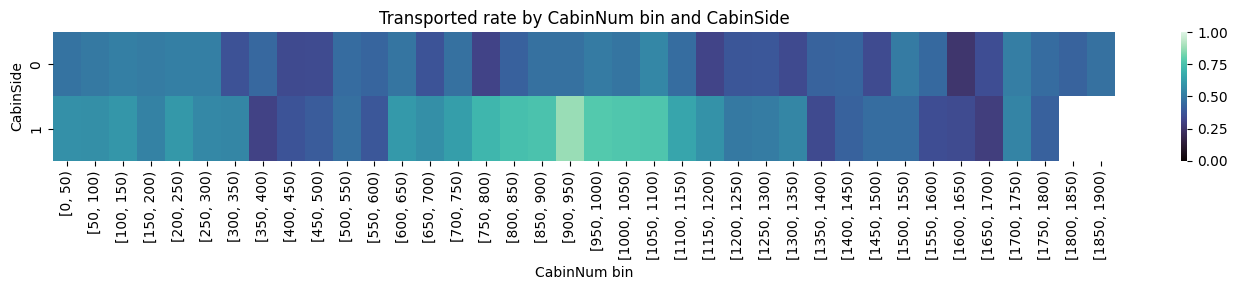

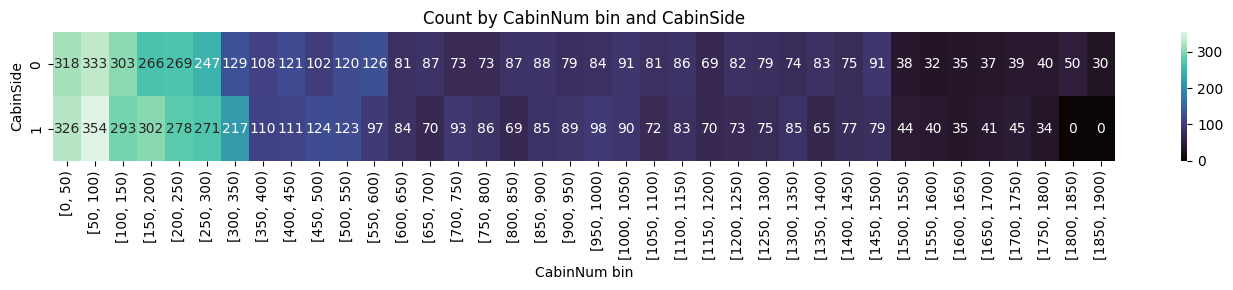

In [76]:
df = train_df.copy()

df = df.dropna(subset=["Transported", "CabinNum", "CabinSide"])
df["CabinSide"] = df["CabinSide"]

bin_size = 50
max_num = int(df["CabinNum"].max())
bins = np.arange(0, max_num + bin_size, bin_size)

df["CabinNum_bin"] = pd.cut(df["CabinNum"], bins=bins, right=False, include_lowest=True)

rate = df.pivot_table(index="CabinSide", columns="CabinNum_bin", values="Transported", aggfunc="mean", observed=False)
count = df.pivot_table(index="CabinSide", columns="CabinNum_bin", values="Transported", aggfunc="count", observed=False)

plt.figure(figsize=[14, 3])
sns.heatmap(rate, vmin=0, vmax=1, cmap="mako")
plt.title("Transported rate by CabinNum bin and CabinSide")
plt.xlabel("CabinNum bin")
plt.ylabel("CabinSide")
plt.tight_layout()
plt.show()

plt.figure(figsize=[14, 3])
sns.heatmap(count, cmap="mako", annot=True, fmt=".0f")
plt.title("Count by CabinNum bin and CabinSide")
plt.xlabel("CabinNum bin")
plt.ylabel("CabinSide")
plt.tight_layout()
plt.show()



In [77]:
df = train_df.copy()
df = df.dropna(subset=["Transported", "CabinNum", "CabinSide"])

df["CabinSide_f"] = df["CabinSide"].astype("string").fillna("Missing")
df["CabinDeck_f"] = df["CabinDeck"].astype("string").fillna("Missing")

# bin CabinNum
bin_size = 50
max_num = int(df["CabinNum"].max())
bins = np.arange(0, max_num + bin_size, bin_size)
df["CabinNum_bin"] = pd.cut(df["CabinNum"], bins=bins, right=False, include_lowest=True)

side_order = sorted(df["CabinSide_f"].unique().tolist())
bin_labels = df["CabinNum_bin"].cat.categories
x_text = [str(b) for b in bin_labels]

def pivots(sub):
    rate = sub.pivot_table(
        index="CabinSide_f", columns="CabinNum_bin", values="Transported",
        aggfunc="mean", observed=False
    ).reindex(index=side_order, columns=bin_labels)

    cnt = sub.pivot_table(
        index="CabinSide_f", columns="CabinNum_bin", values="Transported",
        aggfunc="count", observed=False
    ).reindex(index=side_order, columns=bin_labels)

    return rate.to_numpy(), cnt.to_numpy()

labels = ["All"] + sorted(df["CabinDeck_f"].unique().tolist())
rates, counts = [], []
for lab in labels:
    sub = df if lab == "All" else df[df["CabinDeck_f"] == lab]
    r, c = pivots(sub)
    rates.append(r); counts.append(c)

fig = go.Figure(go.Heatmap(
    z=rates[0],
    x=x_text,
    y=side_order,
    zmin=0, zmax=1,
    colorscale="Magma",
    colorbar=dict(title="Transported rate"),
    customdata=counts[0],
    hovertemplate="Side=%{y}<br>Bin=%{x}<br>Rate=%{z:.3f}<br>n=%{customdata}<extra></extra>",
))

buttons = []
for i, lab in enumerate(labels):
    title = "Transported rate (All decks)" if lab == "All" else f"Transported rate (Deck {lab})"
    buttons.append(dict(
        label=("All decks" if lab == "All" else f"Deck {lab}"),
        method="update",
        args=[{"z": [rates[i]], "customdata": [counts[i]]}, {"title": title}],
    ))

fig.update_layout(
    title="Transported rate (All decks)",
    updatemenus=[dict(buttons=buttons, direction="down", x=1.02, y=1.0)],
    xaxis_title="CabinNum bin",
    yaxis_title="CabinSide",
    margin=dict(l=40, r=220, t=60, b=40),
)

fig.show()

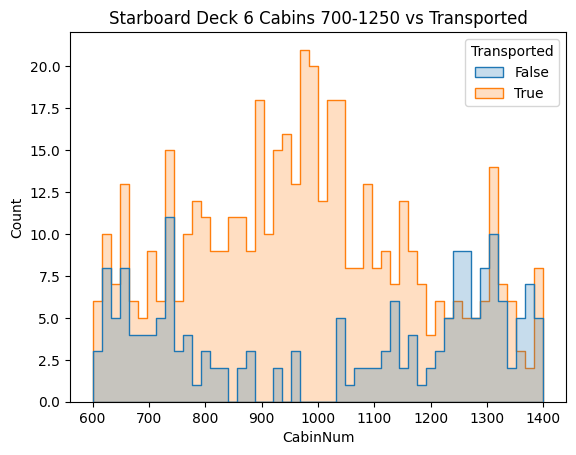

In [78]:
df = train_df.copy()
# 700-1250 Deck 6 CabinSide 1 (S)
df = df[(df["CabinDeck"] == 6) & (df["CabinSide"] == 1) & (df["CabinNum"] >= 600) & (df["CabinNum"] <= 1400)]

sns.histplot(data=df, x="CabinNum", hue="Transported", element="step", bins=50, stat="count", common_norm=False)
plt.title("Starboard Deck 6 Cabins 700-1250 vs Transported")
plt.show()

In [79]:
df = train_df.copy()

df["CabinDeck"] = df["CabinDeck"].astype("string").fillna("Missing")
df["CabinSleep"] = df["CryoSleep"].astype("string").fillna("Missing")

table = df.pivot_table(
    values="Transported",
    index="CabinDeck",
    columns="CryoSleep",
    aggfunc="mean"
)

table

CryoSleep,False,True
CabinDeck,,
0,0.324176,0.941176
1,0.422287,0.992840
19,0.250000,NaN
2,0.462791,0.993197
3,0.277473,0.990385
4,0.286337,0.648810
5,0.301930,0.985455
6,0.350785,0.659259
Missing,0.268519,0.797619


In [80]:
df = train_df.copy()

df["CabinDeck"] = df["CabinDeck"].astype("string").fillna("Missing")
df["CabinSleep"] = df["CryoSleep"].astype("string").fillna("Missing")

table = df.pivot_table(
    values="Transported",
    index="CabinDeck",
    columns="CryoSleep",
    aggfunc="count"
)

table

CryoSleep,False,True
CabinDeck,,
0,182.0,68.0
1,341.0,419.0
19,4.0,NaN
2,430.0,294.0
3,364.0,104.0
4,688.0,168.0
5,2176.0,550.0
6,1146.0,1350.0
Missing,108.0,84.0


## Destination

In [81]:
df = train_df.copy()

df["Destination"] = df["Destination"].astype("string").fillna("Missing")

summary_table(df, "Destination")

,n,rate,delta_vs_overall
Destination,,,
55 Cancri e,1800,0.610000,0.106376
TRAPPIST-1e,5915,0.471175,-0.032449
Missing,182,0.505495,0.001871
PSO J318.5-22,796,0.503769,0.000145


In [82]:
df = train_df.copy()

df["Destintation_f"] = df["Destination"].fillna("Missing")
df["CryoSleep_f"] = df["CryoSleep"].astype("string").fillna("Missing")

table = df.pivot_table(
    index="Destintation_f",
    columns="CryoSleep_f",
    values="Transported",
    aggfunc="mean"
).sort_index().reindex(columns=["True", "False", "Missing"])

table

CryoSleep_f,True,False,Missing
Destintation_f,,,
55 Cancri e,0.928281,0.380531,0.568182
Missing,0.937500,0.338462,0.750000
PSO J318.5-22,0.689295,0.327411,0.421053
TRAPPIST-1e,0.797001,0.315290,0.466667


In [83]:
df = train_df.copy()

df["Destintation_f"] = df["Destination"].fillna("Missing")
df["CryoSleep_f"] = df["CryoSleep"].astype("string").fillna("Missing")

table = df.pivot_table(
    index="Destintation_f",
    columns="CryoSleep_f",
    values="Transported",
    aggfunc="count"
).sort_index().reindex(columns=["True", "False", "Missing"])

table

CryoSleep_f,True,False,Missing
Destintation_f,,,
55 Cancri e,739,1017,44
Missing,48,130,4
PSO J318.5-22,383,394,19
TRAPPIST-1e,1867,3898,150


In [84]:
df = train_df.copy()

df["Destintation_f"] = df["Destination"].fillna("Missing")
df["HomePlanet_f"] = df["HomePlanet"].fillna("Missing")

table = df.pivot_table(
    index="Destintation_f",
    columns="HomePlanet_f",
    values="Transported",
    aggfunc="mean"
).sort_index()

table

HomePlanet_f,Earth,Europa,Mars,Missing
Destintation_f,,,,
55 Cancri e,0.504348,0.689616,0.611399,0.677419
Missing,0.414141,0.648649,0.595238,0.500000
PSO J318.5-22,0.498596,0.736842,0.448980,0.625000
TRAPPIST-1e,0.389229,0.634987,0.511864,0.466667


In [85]:
df = train_df.copy()

df["Destintation_f"] = df["Destination"].fillna("Missing")
df["HomePlanet_f"] = df["HomePlanet"].fillna("Missing")

table = df.pivot_table(
    index="Destintation_f",
    columns="HomePlanet_f",
    values="Transported",
    aggfunc="count"
).sort_index()

table

HomePlanet_f,Earth,Europa,Mars,Missing
Destintation_f,,,,
55 Cancri e,690,886,193,31
Missing,99,37,42,4
PSO J318.5-22,712,19,49,16
TRAPPIST-1e,3101,1189,1475,150


55 Cancri e could be correlated with being transported.

## Age

In [86]:
df = train_df.copy()

bin_size = 5
max_num = int(df["Age"].max())
bins = np.arange(0, max_num + bin_size, bin_size)
df["Age_bin"] = pd.cut(df["Age"], bins=bins, right=False, include_lowest=True)

df["Age_bin"] = df["Age_bin"].astype("string").fillna("Missing")

summary_table(df, "Age_bin")

,n,rate,delta_vs_overall
Age_bin,,,
"[0.0, 5.0)",466,0.768240,0.264617
"[75.0, 80.0)",14,0.357143,-0.146481
"[5.0, 10.0)",213,0.586854,0.083231
"[10.0, 15.0)",406,0.566502,0.062879
"[65.0, 70.0)",61,0.442623,-0.061001
"[20.0, 25.0)",1495,0.442809,-0.060814
"[30.0, 35.0)",910,0.452747,-0.050876
"[35.0, 40.0)",825,0.465455,-0.038169
"[70.0, 75.0)",32,0.468750,-0.034874


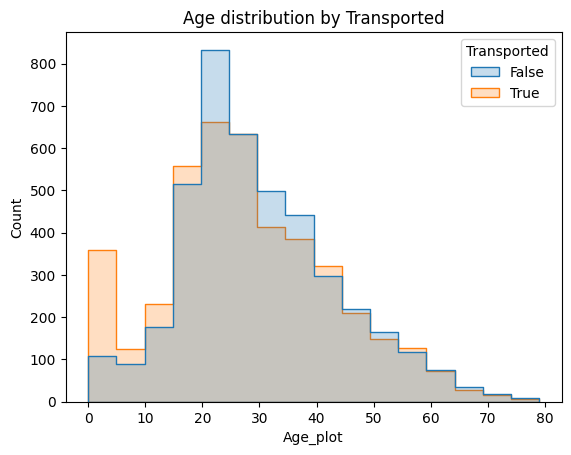

In [87]:
df = train_df.copy()
df["Age_plot"] = df["Age"]

sns.histplot(data=df, x="Age_plot", hue="Transported", binwidth=5, element="step", stat="count", common_norm=False)
plt.title("Age distribution by Transported")
plt.show()

Looking at the histogram it appears that passengers that are about 6 or under are more likely to be transported so I will explore that.

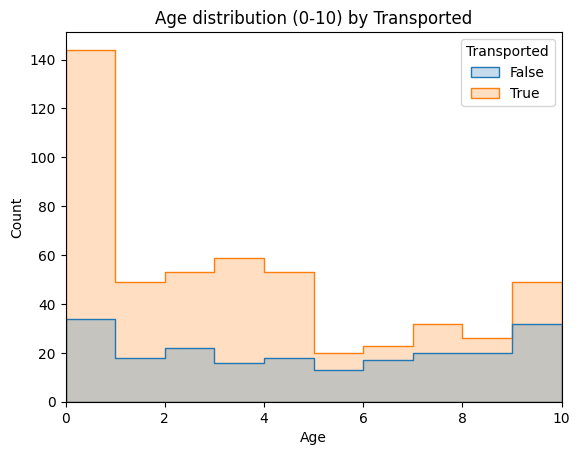

In [88]:
df = train_df.dropna(subset=["Age"])
df = df[(df["Age"] >= 0) & (df["Age"] <= 10)]

sns.histplot(data=df, x="Age", hue="Transported", bins=10, binrange=(0, 10), element="step", stat="count", common_norm=False)
plt.xlim(0, 10)
plt.title("Age distribution (0-10) by Transported")
plt.show()

In [89]:
X = df[["Age"]]
y = df["Transported"]

tree = DecisionTreeClassifier(max_depth=2, min_samples_leaf=200, random_state=0)
tree.fit(X, y)
tree.tree_.threshold

array([ 4.5,  1.5, -2. , -2. , -2. ])

In [90]:
df = train_df.copy()

df = df[(df["Age"] <= 4.5)]
df["Transported"].mean()

np.float64(0.7682403433476395)

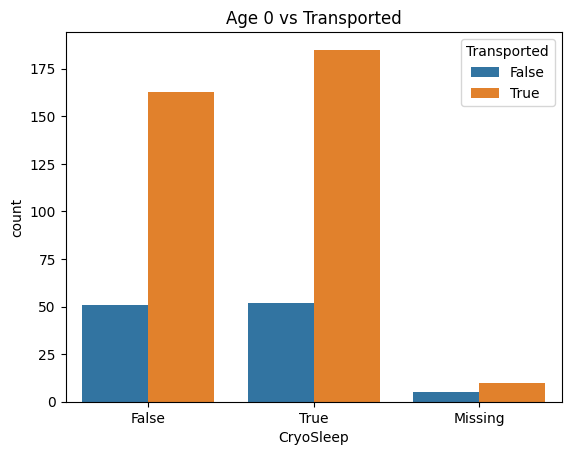

In [91]:
df = train_df.copy()
df = df[(df["Age"] <= 4.5)]
df["CryoSleep"] = df["CryoSleep"].astype("string").fillna("Missing")

sns.countplot(data=df, x="CryoSleep", hue="Transported")
plt.title("Age 0 vs Transported")
plt.show()

Age is prerdictive mainly in passengers ages 0-4 have a substantially higher transpoted rate (~0.77, n=466) versus the baseline.

## VIP

In [92]:
df = train_df.copy()

df["VIP"] = df["VIP"].astype("string").fillna("Missing")

summary_table(df, "VIP")

,n,rate,delta_vs_overall
VIP,,,
True,199,0.381910,-0.121714
Missing,203,0.512315,0.008692
False,8291,0.506332,0.002709


In [93]:
df = train_df.copy()

df["VIP_f"] = df["VIP"].astype("string").fillna("Missing")
df["CryoSleep_f"] = df["CryoSleep"].astype("string").fillna("Missing")

table = df.pivot_table(
    index="VIP_f",
    columns="CryoSleep_f",
    values="Transported",
    aggfunc="mean"
).sort_index().reindex(columns=["True", "False", "Missing"])

table

CryoSleep_f,True,False,Missing
VIP_f,,,
False,0.818089,0.328213,0.502415
Missing,0.746667,0.388430,0.142857
True,1.000000,0.308571,0.333333


In [94]:
df = train_df.copy()

df["VIP_f"] = df["VIP"].astype("string").fillna("Missing")
df["CryoSleep_f"] = df["CryoSleep"].astype("string").fillna("Missing")

table = df.pivot_table(
    index="VIP_f",
    columns="CryoSleep_f",
    values="Transported",
    aggfunc="count"
).sort_index().reindex(columns=["True", "False", "Missing"])

table

CryoSleep_f,True,False,Missing
VIP_f,,,
False,2941,5143,207
Missing,75,121,7
True,21,175,3


VIP seems to be confounded with CryoSleep given that the majority of people who had VIP were not in CryoSleep, although all 21 people who were VIP and in Cryosleep were transported. 

Could Cross check with Cabin to see if people with VIP were near each other.

In [95]:
df = train_df.copy()

df = df[(df["VIP"] == True) & (df["CryoSleep"] == True)]

drop_cols = ["Name", "Age", "VIP", "CryoSleep", "Cabin", "PassengerId"]
df = df.drop(columns=drop_cols, errors="ignore")

df

,HomePlanet,Destination,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,CabinDeck,CabinNum,CabinSide
365,NaN,55 Cancri e,0.0,0.0,0.0,0.0,0.0,True,402,3,15,1
589,Europa,TRAPPIST-1e,0.0,0.0,0.0,0.0,0.0,True,612,1,25,0
1849,Europa,55 Cancri e,0.0,0.0,0.0,0.0,0.0,True,1976,1,82,1
2394,Europa,55 Cancri e,0.0,0.0,0.0,0.0,0.0,True,2572,2,93,1
2675,Europa,TRAPPIST-1e,0.0,0.0,0.0,0.0,0.0,True,2866,2,110,1
3104,Europa,TRAPPIST-1e,0.0,0.0,0.0,NaN,0.0,True,3349,2,111,0
4071,Europa,TRAPPIST-1e,0.0,0.0,0.0,0.0,0.0,True,4348,1,142,0
4155,Europa,55 Cancri e,0.0,0.0,0.0,0.0,0.0,True,4441,1,144,0
4401,Europa,55 Cancri e,0.0,0.0,0.0,0.0,0.0,True,4668,2,180,1
4503,Europa,TRAPPIST-1e,0.0,0.0,0.0,0.0,0.0,True,4786,1,160,0


## GroupID

In [96]:
df = train_df.copy()

df["InGroup"] = df.groupby("GroupId")["GroupId"].transform("size").gt(1)
df["InGroup"] = df["InGroup"].astype("string").fillna("Missing")

summary_table(df, "InGroup")

,n,rate,delta_vs_overall
InGroup,,,
True,3888,0.566872,0.063249
False,4805,0.452445,-0.051178


In [97]:
df = train_df.copy()

df["GroupSize"] = df.groupby("GroupId")["GroupId"].transform("size")
df["GroupSize"] = df["GroupSize"].astype("string").fillna("Missing")

summary_table(df, "GroupSize")

,n,rate,delta_vs_overall
GroupSize,,,
4,412,0.640777,0.137153
6,174,0.614943,0.111319
8,104,0.394231,-0.109393
3,1020,0.593137,0.089514
5,265,0.592453,0.088829
1,4805,0.452445,-0.051178
7,231,0.541126,0.037502
2,1682,0.538050,0.034426


In [98]:
df = train_df.copy()

df["GroupSizeCapped"] = df.groupby("GroupId")["GroupId"].transform("size").clip(upper=6).astype("string")
df.loc[df["GroupSizeCapped"] == "6", "GroupSizeCapped"] = "6+"
df["GroupSizeCapped"] = df["GroupSizeCapped"].astype("string").fillna("Missing")

summary_table(df, "GroupSizeCapped")

,n,rate,delta_vs_overall
GroupSizeCapped,,,
4,412,0.640777,0.137153
3,1020,0.593137,0.089514
5,265,0.592453,0.088829
1,4805,0.452445,-0.051178
2,1682,0.538050,0.034426
6+,509,0.536346,0.032722


In [99]:
df = train_df.copy()

df["GroupSize"] = df.groupby("GroupId")["GroupId"].transform("size")
df["GroupSize"] = df["GroupSize"].astype("string").fillna("Missing")
df["CryoSleep"] = df["CryoSleep"].astype("string").fillna("Missing")

table = df.pivot_table(
    index="GroupSize",
    columns="CryoSleep",
    values="Transported",
    aggfunc="mean"
).reindex(columns=["True", "False", "Missing"])

table

CryoSleep,True,False,Missing
GroupSize,,,
1,0.779195,0.301122,0.439252
2,0.891509,0.314629,0.500000
3,0.858156,0.393357,0.680000
4,0.899371,0.460251,0.785714
5,0.833333,0.411348,0.400000
6,0.763889,0.525773,0.200000
7,0.716981,0.403361,0.166667
8,0.621622,0.261538,0.500000


In [100]:
df = train_df.copy()

df["GroupSize"] = df.groupby("GroupId")["GroupId"].transform("size")
df["GroupSize"] = df["GroupSize"].astype("string").fillna("Missing")
df["CryoSleep"] = df["CryoSleep"].astype("string").fillna("Missing")

table = df.pivot_table(
    index="GroupSize",
    columns="CryoSleep",
    values="Transported",
    aggfunc="count"
).reindex(columns=["True", "False", "Missing"])

table

CryoSleep,True,False,Missing
GroupSize,,,
1,1490,3208,107
2,636,998,48
3,423,572,25
4,159,239,14
5,114,141,10
6,72,97,5
7,106,119,6
8,37,65,2


In [101]:
df = train_df.copy()

df["GroupSize"] = df.groupby("GroupId")["GroupId"].transform("size")
df["GroupSize"] = df["GroupSize"].astype("string").fillna("Missing")
df["CabinDeck"] = df["CabinDeck"].astype("string").fillna("Missing")

table = df.pivot_table(
    index="GroupSize",
    columns="CabinDeck",
    aggfunc="size"
)

table

CabinDeck,0,1,19,2,3,4,5,6,Missing
GroupSize,,,,,,,,,
1,81.0,228.0,5.0,257.0,232.0,556.0,1815.0,1532.0,99.0
2,64.0,281.0,NaN,203.0,156.0,167.0,438.0,326.0,47.0
3,61.0,104.0,NaN,100.0,32.0,84.0,316.0,305.0,18.0
4,36.0,90.0,NaN,63.0,14.0,18.0,108.0,77.0,6.0
5,8.0,43.0,NaN,52.0,19.0,23.0,23.0,83.0,14.0
6,6.0,6.0,NaN,52.0,11.0,13.0,5.0,77.0,4.0
7,NaN,27.0,NaN,20.0,14.0,15.0,49.0,99.0,7.0
8,NaN,NaN,NaN,NaN,NaN,NaN,40.0,60.0,4.0


Groups of 8 are only found on Decks 5 and 6 which we already saw was correlated with being Transported

In [102]:
df = train_df.copy()

gmean = df.groupby("GroupId")["Transported"].mean()

pct_groups = pd.Series({
    "all_0": (gmean == 0).mean(),
    "all_1": (gmean == 1).mean(),
    "mixed": ((gmean > 0) & (gmean < 1)).mean()
})

pct_groups

all_0    0.461316
all_1    0.410487
mixed    0.128197
dtype: float64

~87% of people share the outcome of their group

## Expenses

In [103]:
df = train_df.copy()

expense_columns = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

df["TotalExpenses"] = df[expense_columns].fillna(0).sum(axis=1)

cols = expense_columns + ["TotalExpenses"]

summary = pd.DataFrame(index=cols)
summary["missing"] = df[cols].isna().mean()

summary["zero"] = (df[cols] == 0).mean()
summary["zero_fillna"] = (df[cols].fillna(0) == 0).mean()

summary["median"] = df[cols].median(numeric_only=True)
summary["p90"] = df[cols].quantile(0.90, numeric_only=True)
summary["p95"] = df[cols].quantile(0.95, numeric_only=True)

summary

,missing,zero,zero_fillna,median,p90,p95
RoomService,0.020821,0.641551,0.662372,0.0,753.0,1274.25
FoodCourt,0.021051,0.627631,0.648683,0.0,1026.0,2748.50
ShoppingMall,0.023927,0.642701,0.666628,0.0,619.6,927.80
Spa,0.021051,0.612447,0.633498,0.0,732.0,1607.10
VRDeck,0.021627,0.632118,0.653744,0.0,732.6,1534.20
TotalExpenses,0.000000,0.420223,0.420223,716.0,3838.4,6457.60


In [104]:
df = train_df.copy()

expense_columns = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

df[expense_columns].isna().sum()

RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
dtype: int64

In [105]:
df = train_df.copy()
expense_columns = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

df["SpendMissingCount"] = df[expense_columns].isna().sum(axis=1)

summary_table(df, "SpendMissingCount")

,n,rate,delta_vs_overall
SpendMissingCount,,,
2,35,0.542857,0.039234
1,873,0.512027,0.008404
0,7785,0.502505,-0.001119


In [106]:
df = train_df.copy()
expense_columns = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

df["TotalExpenses"] = df[expense_columns].fillna(0).sum(axis=1)
df["NoSpend"] = df["TotalExpenses"].eq(0)

summary_table(df, "NoSpend")

,n,rate,delta_vs_overall
NoSpend,,,
True,3653,0.786477,0.282853
False,5040,0.298611,-0.205012


In [107]:
df = train_df.copy()
expense_columns = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

df["NumAmenitiesUsed"] = (df[expense_columns].fillna(0).gt(0)).sum(axis=1)

summary_table(df, "NumAmenitiesUsed")

,n,rate,delta_vs_overall
NumAmenitiesUsed,,,
0,3653,0.786477,0.282853
4,1225,0.269388,-0.234236
2,1224,0.299837,-0.203787
3,2068,0.306576,-0.197047
5,252,0.317460,-0.186163
1,271,0.346863,-0.156760


Try removing people in cryosleep

In [108]:
df = train_df.copy()
df = df[(df["CryoSleep"] == False)]

expense_columns = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

df["TotalExpenses"] = df[expense_columns].fillna(0).sum(axis=1)
df["NoSpend"] = df["TotalExpenses"].eq(0)

summary_table(df, "NoSpend")

,n,rate,delta_vs_overall
NoSpend,,,
True,518,0.61583,0.286909
False,4921,0.29872,-0.030201


In [109]:
df = train_df.copy()
df = df[(df["CryoSleep"] == False)]

expense_columns = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

df["NumAmenitiesUsed"] = (df[expense_columns].fillna(0).gt(0)).sum(axis=1)

summary_table(df, "NumAmenitiesUsed")

,n,rate,delta_vs_overall
NumAmenitiesUsed,,,
0,518,0.615830,0.286909
4,1192,0.270134,-0.058787
2,1190,0.297479,-0.031442
3,2030,0.307882,-0.021039
1,266,0.342105,0.013185
5,243,0.320988,-0.007933


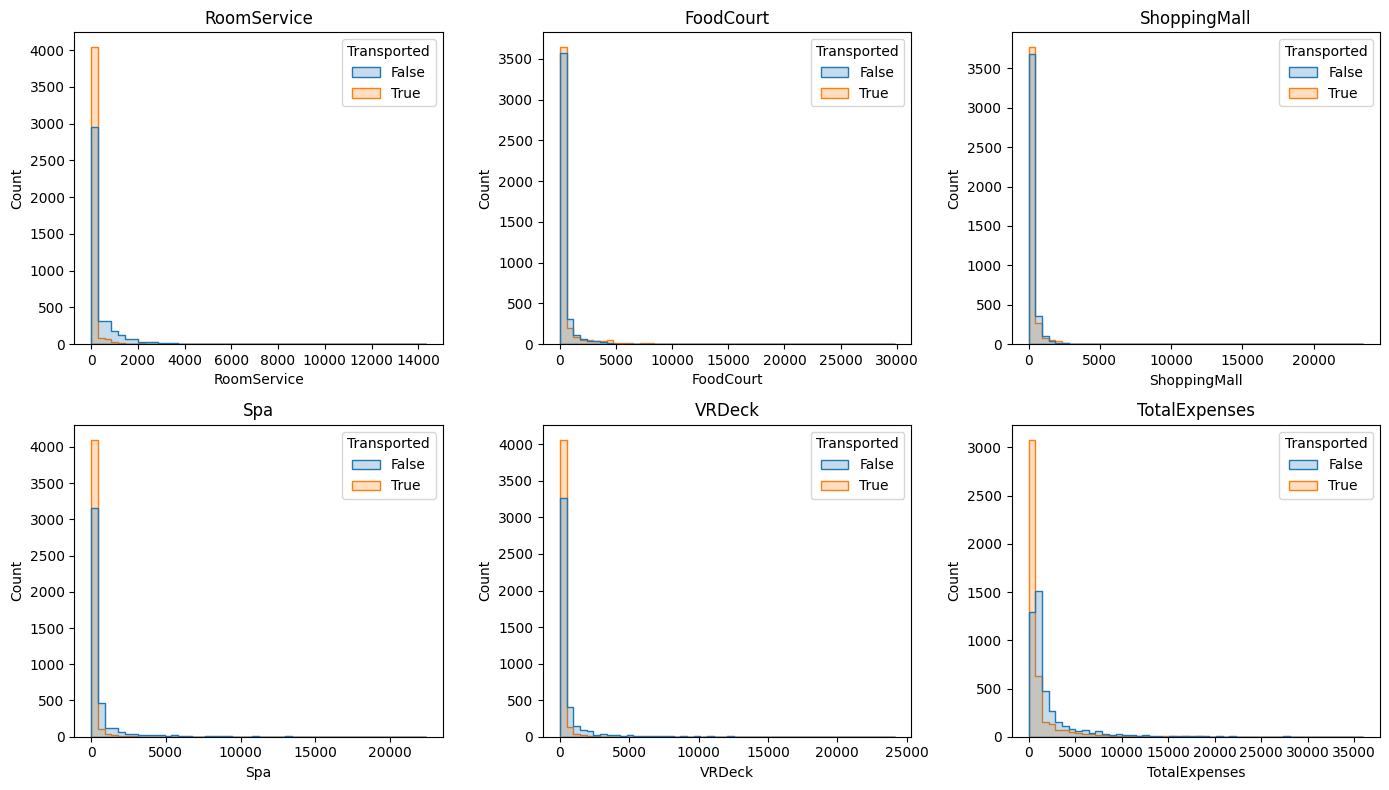

In [110]:
df = train_df.copy()

expense_columns = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

df["TotalExpenses"] = df[expense_columns].fillna(0).sum(axis=1)

cols = expense_columns + ["TotalExpenses"]
ncols = 3
nrows = (len(expense_columns) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4*nrows))
axes = axes.ravel()

for i, c in enumerate(cols):
    ax = axes[i]
    sns.histplot(data=df, x=c, hue="Transported", bins=50, element="step", stat="count", common_norm=False, ax=ax)
    ax.set_title(c)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

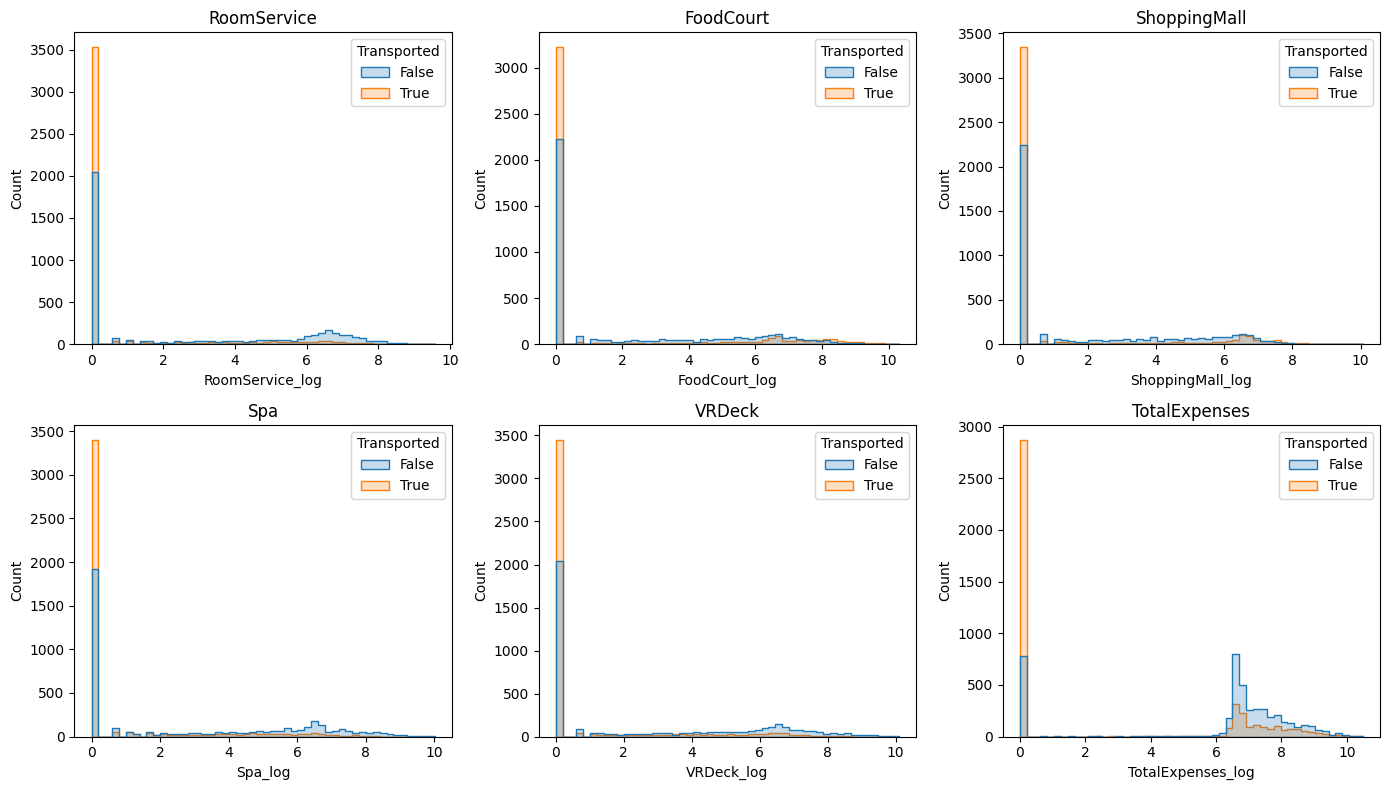

In [111]:
df = train_df.copy()

expense_columns = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

df["TotalExpenses"] = df[expense_columns].fillna(0).sum(axis=1)

cols = expense_columns + ["TotalExpenses"]

for col in cols:
    df[f"{col}_log"] = np.log1p(df[col])

ncols = 3
nrows = (len(expense_columns) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4*nrows))
axes = axes.ravel()

for i, c in enumerate(cols):
    ax = axes[i]
    sns.histplot(data=df, x=f"{c}_log", hue="Transported", bins=50, element="step", stat="count", common_norm=False, ax=ax)
    ax.set_title(c)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

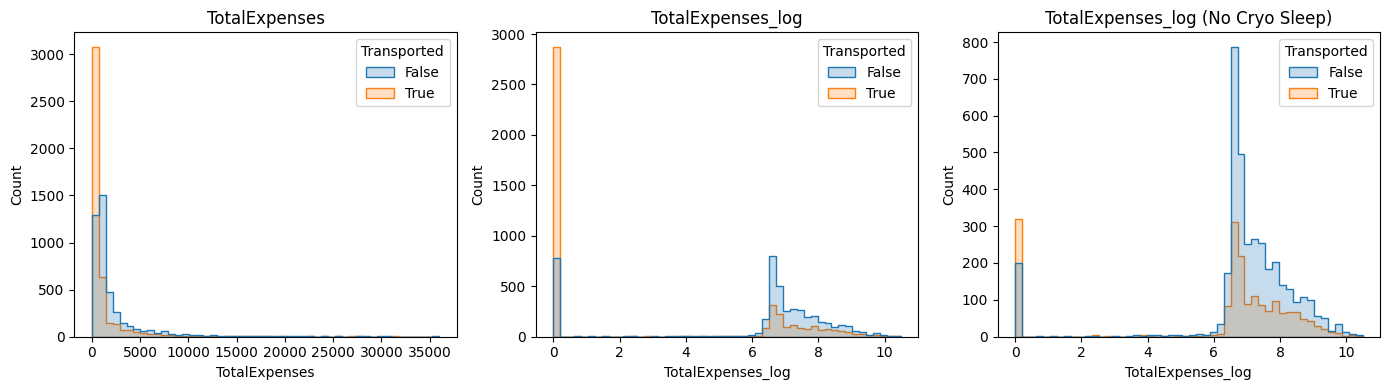

In [112]:
df = train_df.copy()

expense_columns = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

df["TotalExpenses"] = df[expense_columns].fillna(0).sum(axis=1)
df["TotalExpenses_log"] = np.log1p(df["TotalExpenses"])

df_no_cryo = df[(df["CryoSleep"] == False)].copy()

cols = expense_columns + ["TotalExpenses"]
ncols = 3
nrows = 1

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4*nrows))
axes = axes.ravel()

ax = axes[0]
sns.histplot(data=df, x="TotalExpenses", hue="Transported", bins=50, element="step", stat="count", common_norm=False, ax=ax)
ax.set_title("TotalExpenses")

ax = axes[1]
sns.histplot(data=df, x="TotalExpenses_log", hue="Transported", bins=50, element="step", stat="count", common_norm=False, ax=ax)
ax.set_title("TotalExpenses_log")

ax = axes[2]
sns.histplot(data=df_no_cryo, x="TotalExpenses_log", hue="Transported", bins=50, element="step", stat="count", common_norm=False, ax=ax)
ax.set_title("TotalExpenses_log (No Cryo Sleep)")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

# Feature List

- CryoSleep
- HomePlanet
- Destination
- Cabin Num (binned)
- Cabin Deck
- Cabin Side
- Age
- AgeMissing
- VIP
- GroupSizeCapped (Capped at 6)
- NoSpend
- SpendMissingCount
- NumAmenitiesUsed
- TotalExpenses_log (log1p)

- GroupId (GroupKFold validation)